<a href="https://www.kaggle.com/code/yashwinibansal/yolov1-implementation-with-batchnorm?scriptVersionId=124705427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

import os
import sys

import pandas as pd
from PIL import Image

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
""" 
YOLOv1 architechture

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page3

tuples description:
    (kernel_size, filters, stride, padding) 
maxpooling with stride 2x2 and kernel 2x2
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",                  # maxpooling
    (3, 192, 1, 1),
    "M",                  # maxpooling
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",                  # maxpooling
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],       # tuples and number of repeats=4
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",                  # maxpooling
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],       # tuples and number of repeats=2
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [ nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [5]:
# def test(S=7, B=2, C=20):
#     model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
#     x = torch.randn((2, 3, 448, 448))
#     print(model(x).shape)
    
# test()

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [7]:
"""
Implementation of Yolo Loss Function from the original yolo paper

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page4
"""

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S - split size of image
        B - number of boxes
        C - number of classes
        """
        self.S = S
        self.B = B
        self.C = C

        # for calculating loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # input predictions are shaped (BATCH_SIZE, S * S * (C + B * 5)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out the prediction with highest Iou
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30]
            + (1 - bestbox) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

In [8]:
"""
load the Pascal VOC dataset
"""

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box relative to the cell
            """
            width_cell, height_cell = width * self.S, height * self.S

            # If no object already found for specific cell i,j
            # restrict to ONE object per cell
            
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor( [x_cell, y_cell, width_cell, height_cell] )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [9]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    """
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones that belong to the current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [10]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [11]:
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [12]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 500
NUM_WORKERS = 2
PIN_MEMORY = True
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"

In [13]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [14]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [15]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [16]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

In [17]:
train_dataset = VOCDataset("../input/pascalvoc-yolo/100examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)
test_dataset = VOCDataset("../input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

In [18]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [19]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [20]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [21]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Train mAP: 0.0


100%|██████████| 6/6 [00:04<00:00,  1.49it/s, loss=976]

Mean loss was 940.7796325683594


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=431]

Mean loss was 562.18359375


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=540]

Mean loss was 442.797124226888


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=443]

Mean loss was 378.1818339029948


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=376]

Mean loss was 315.126225789388


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=161]

Mean loss was 270.0555928548177


Train mAP: 3.658179821286467e-06


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=180]

Mean loss was 232.9347890218099


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=201]

Mean loss was 199.6090545654297


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=231]

Mean loss was 182.00615946451822


Train mAP: 0.00675853481516242


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=136]

Mean loss was 171.9614995320638


Train mAP: 0.05601818114519119


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=124]

Mean loss was 162.65868631998697


Train mAP: 0.11397591978311539


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=183]

Mean loss was 152.8522974650065


Train mAP: 0.25203099846839905


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=157]

Mean loss was 137.19288635253906


Train mAP: 0.2679360806941986


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=111]

Mean loss was 129.44241841634116


Train mAP: 0.3553893566131592


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=129]

Mean loss was 116.048402150472


Train mAP: 0.4274466633796692


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=113]

Mean loss was 97.65899403889973


Train mAP: 0.5400823950767517


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=85.5]

Mean loss was 91.36527760823567


Train mAP: 0.595420241355896


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=108]

Mean loss was 91.44882202148438


Train mAP: 0.6727896928787231


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=89.4]

Mean loss was 86.92728424072266


Train mAP: 0.6657169461250305


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=53.6]

Mean loss was 74.76633071899414


Train mAP: 0.7458534836769104


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=76.4]

Mean loss was 79.07821528116862


Train mAP: 0.6924792528152466


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=93.4]

Mean loss was 75.6411501566569


Train mAP: 0.7549721598625183


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=77.8]

Mean loss was 73.26049359639485


Train mAP: 0.7311869263648987


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=67.3]

Mean loss was 68.62819353739421


Train mAP: 0.8044832348823547


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=60.9]

Mean loss was 67.4366963704427


Train mAP: 0.8281194567680359


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=82]

Mean loss was 64.47331937154134


Train mAP: 0.8527950048446655


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=87.1]

Mean loss was 66.23033332824707


Train mAP: 0.8585106730461121


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=76.5]

Mean loss was 64.73691813151042


Train mAP: 0.8073242902755737


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=44.9]

Mean loss was 54.078687032063804


Train mAP: 0.8530066609382629


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=75.3]

Mean loss was 55.0507869720459


Train mAP: 0.8651921153068542


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=47]

Mean loss was 57.71076583862305


Train mAP: 0.8269518613815308


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=52]

Mean loss was 51.65052604675293


Train mAP: 0.8297724723815918


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=61.8]

Mean loss was 54.174839655558266


Train mAP: 0.8439270257949829


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=66.7]

Mean loss was 53.102912267049156


Train mAP: 0.8478420376777649


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=59.2]

Mean loss was 50.69114875793457


Train mAP: 0.7754469513893127


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=55.3]

Mean loss was 49.620823542277016


Train mAP: 0.8604739308357239


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=30.5]

Mean loss was 52.12800852457682


Train mAP: 0.8670584559440613


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=38.6]

Mean loss was 45.08748435974121


Train mAP: 0.882846474647522


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=56.6]

Mean loss was 42.03720283508301


Train mAP: 0.8704441785812378


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=34.1]

Mean loss was 45.957159678141274


Train mAP: 0.9357954263687134


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=77.5]

Mean loss was 49.837958653767906


Train mAP: 0.9021209478378296


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=54.8]

Mean loss was 45.88085619608561


Train mAP: 0.8973156809806824


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=31.3]

Mean loss was 41.15645949045817


Train mAP: 0.872155487537384


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=47.4]

Mean loss was 44.785801569620766


Train mAP: 0.8344009518623352


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=52.9]

Mean loss was 40.53583272298177


Train mAP: 0.8819066286087036


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=38.2]

Mean loss was 39.920087814331055


Train mAP: 0.8203039169311523


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=39.7]

Mean loss was 39.43407917022705


Train mAP: 0.8514034152030945


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=34]

Mean loss was 42.79296875


Train mAP: 0.8608585596084595


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=50.3]

Mean loss was 38.08016554514567


Train mAP: 0.88777095079422


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=42.6]

Mean loss was 38.17210038503011


Train mAP: 0.8822146654129028


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=28.9]

Mean loss was 39.08958466847738


Train mAP: 0.9038172960281372


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=25.9]

Mean loss was 37.2222785949707


Train mAP: 0.8917611241340637


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=35.3]

Mean loss was 33.43030675252279


Train mAP: 0.8766511678695679


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=30]

Mean loss was 33.06971708933512


Train mAP: 0.8886955976486206


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=55.7]

Mean loss was 34.89145151774088


Train mAP: 0.8825114369392395


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=30.8]

Mean loss was 32.59232139587402


Train mAP: 0.8799642324447632


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=30.9]

Mean loss was 32.342549641927086


Train mAP: 0.9032702445983887


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=41.3]

Mean loss was 33.80403264363607


Train mAP: 0.8741922378540039


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=27.6]

Mean loss was 35.9117317199707


Train mAP: 0.888055682182312


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=22.1]

Mean loss was 33.35994211832682


Train mAP: 0.8408981561660767


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=35.7]

Mean loss was 33.40919431050619


Train mAP: 0.9080774188041687


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=20.4]

Mean loss was 31.44702370961507


Train mAP: 0.9314123392105103


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=26]

Mean loss was 29.699896812438965


Train mAP: 0.8633424639701843


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=58.2]

Mean loss was 32.59500471750895


Train mAP: 0.865165114402771


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=37]

Mean loss was 30.686541239420574


Train mAP: 0.8616636395454407


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=25.3]

Mean loss was 26.127950032552082


Train mAP: 0.8300694227218628


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=31.3]

Mean loss was 28.186294555664062


Train mAP: 0.8584856986999512


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=26.3]

Mean loss was 26.07307497660319


Train mAP: 0.8729000091552734


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=27]

Mean loss was 26.034974733988445


Train mAP: 0.9029703140258789


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=18.2]

Mean loss was 27.212929725646973


Train mAP: 0.9029119610786438


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=31.5]

Mean loss was 28.055290857950848


Train mAP: 0.9144013524055481


100%|██████████| 6/6 [00:02<00:00,  2.02it/s, loss=20.4]

Mean loss was 27.73328971862793


Train mAP: 0.8808693289756775


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=31.6]

Mean loss was 26.200218200683594


Train mAP: 0.9206423759460449


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=25]

Mean loss was 26.287891070048016


Train mAP: 0.8999907970428467


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=29.9]

Mean loss was 30.427159945170086


Train mAP: 0.9342120289802551


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=21]

Mean loss was 28.757678985595703


Train mAP: 0.8592007756233215


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=34.3]

Mean loss was 28.92807165781657


Train mAP: 0.8575965166091919


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=26.9]

Mean loss was 29.503573099772137


Train mAP: 0.8157399892807007


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=39.9]

Mean loss was 27.67831548055013


Train mAP: 0.877278208732605


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=19]

Mean loss was 26.733461380004883


Train mAP: 0.8424273729324341


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=25.7]

Mean loss was 23.676385561625164


Train mAP: 0.876808762550354


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=28.1]

Mean loss was 23.627823193868


Train mAP: 0.8538748025894165


100%|██████████| 6/6 [00:03<00:00,  1.94it/s, loss=20.6]

Mean loss was 22.75014130274455


Train mAP: 0.8801584243774414


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=15.3]

Mean loss was 19.946916898091633


Train mAP: 0.9224207997322083


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=20.9]

Mean loss was 19.52698580423991


Train mAP: 0.9033535718917847


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=15.5]

Mean loss was 18.444707075754803


Train mAP: 0.8782655000686646


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=26.6]

Mean loss was 20.87196985880534


Train mAP: 0.9352045059204102


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=20.1]

Mean loss was 19.99712594350179


Train mAP: 0.9102588891983032


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=21.8]

Mean loss was 19.07848612467448


Train mAP: 0.8282805681228638


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=17.7]

Mean loss was 20.33625300725301


Train mAP: 0.8324072957038879


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=27.6]

Mean loss was 22.113998730977375


Train mAP: 0.9067587852478027


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=24.1]

Mean loss was 22.353293259938557


Train mAP: 0.901485800743103


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=22.5]

Mean loss was 19.328535556793213


Train mAP: 0.821648895740509


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=28.2]

Mean loss was 24.67518488566081


Train mAP: 0.8501258492469788


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=30.8]

Mean loss was 24.61364682515462


Train mAP: 0.8541706800460815


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=38.4]

Mean loss was 25.84032980600993


Train mAP: 0.8708162307739258


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=27.9]

Mean loss was 26.751242955525715


Train mAP: 0.9221248626708984


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=26.5]

Mean loss was 26.53320598602295


Train mAP: 0.8802014589309692


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=23]

Mean loss was 23.877971013387043


Train mAP: 0.8665297627449036


100%|██████████| 6/6 [00:03<00:00,  1.94it/s, loss=13.8]

Mean loss was 21.872077624003094


Train mAP: 0.8931956887245178


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=15.9]

Mean loss was 21.989213307698567


Train mAP: 0.9225705862045288


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=15.9]

Mean loss was 19.28112729390462


Train mAP: 0.9622297286987305


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=23.7]

Mean loss was 18.07955280939738


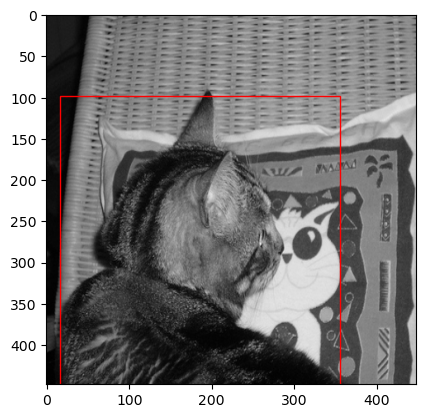

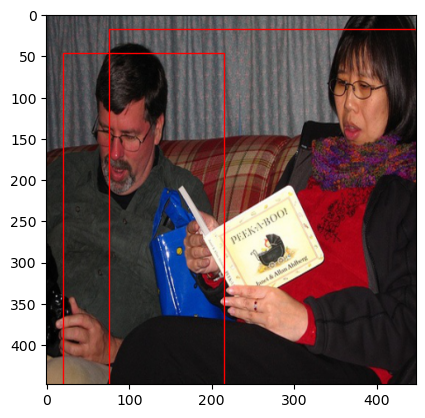

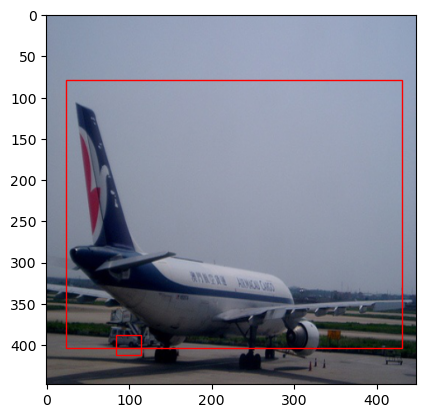

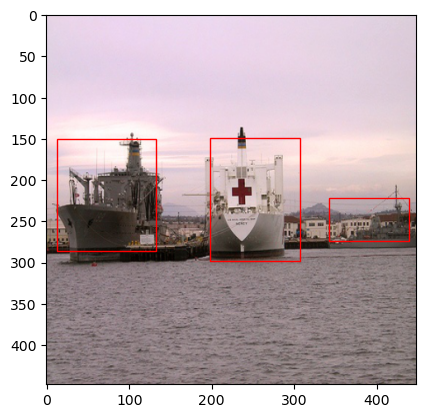

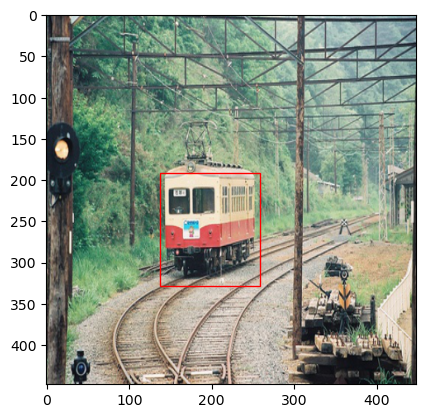

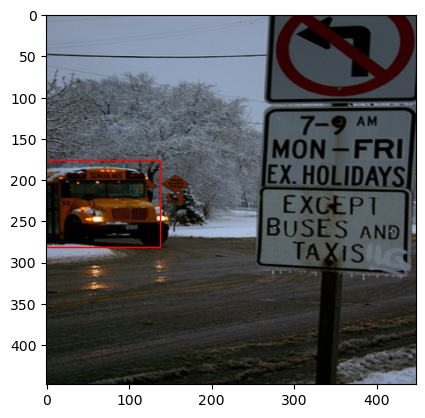

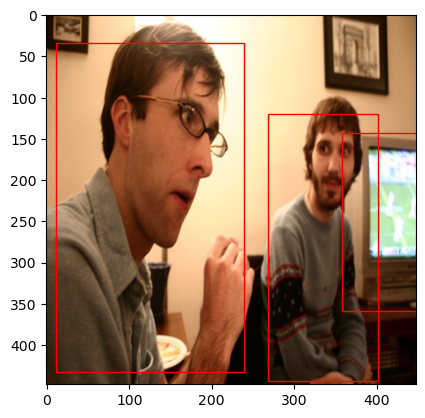

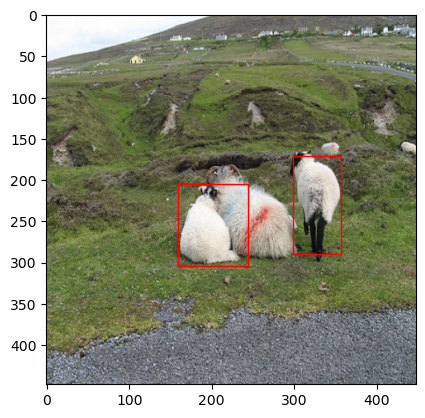

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [22]:
for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")

    train_fn(train_loader, model, optimizer, loss_fn)
    
    if mean_avg_prec > 0.95:
        for x, y in train_loader:
            x = x.to(DEVICE)
            for idx in range(8):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            import sys
            sys.exit()